In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score)
from sklearn.utils import resample

%matplotlib inline

import logging

import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import resample
from torch.utils.data import DataLoader, TensorDataset

import random

In [2]:
torch.manual_seed(42)
random.seed(42)

In [10]:
df = pd.read_csv("WISDM_ar_v1.1_raw.txt", sep = ' ', header = None)

df['lenght'] = df[0].apply(lambda x: x.split(',')).apply(lambda x: len(x))
filtred_df = df[~df['lenght'].isin([7, 11])]
filtred_df[0] = filtred_df[0].apply(lambda x: x.split(','))

columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
for i, el in enumerate(columns):
  if i != len(columns)-1:
    filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i])
  else:
    filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i][:-1])

filtred_df = filtred_df.drop(columns = [0, 'lenght', 'timestamp'])

/tmp/ipykernel_21079/379243730.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtred_df[0] = filtred_df[0].apply(lambda x: x.split(','))
/tmp/ipykernel_21079/379243730.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtred_df[f'{el}'] = filtred_df[0].apply(lambda x: x[i])
/tmp/ipykernel_21079/379243730.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [11]:
def transform_activity(x):
  if x in ['Jogging', 'Upstairs', 'Downstairs']:
    return 1
  elif x in ['Walking', 'Sitting', 'Standing']:
    return 0
filtred_df.activity = filtred_df.activity.apply(lambda x: transform_activity(x))

In [12]:
le = preprocessing.LabelEncoder()
filtred_df['activity'] = le.fit_transform(filtred_df['activity'])

def transform(x):
  try:
    x = float(x)
  except ValueError:
    x = np.nan
  return x

for el in filtred_df.columns:
  filtred_df[el] = filtred_df[el].apply(lambda x: transform(x))

In [13]:
unique_users = list(filtred_df["user"].unique())
random.shuffle(unique_users)

In [14]:
for col in ['x-axis', 'y-axis', 'z-axis']:
  mean_value = filtred_df[col].mean()
  sigma = filtred_df[col].std()
  filtred_df[col] = filtred_df[col].apply(lambda x: (x-mean_value)/sigma)

In [15]:
def group_by_user(df, user):
  return df[df['user'] == user].reset_index(drop = True)

def create_window(df, overlay, window_size, train_x, train_y):
  for i in range(0, df.shape[0], overlay):
    df_sub = df.iloc[i:i+window_size]

    if df_sub.shape[0] == window_size:
      train_x.append(df_sub[['x-axis', 'y-axis', 'z-axis']].to_numpy())
      train_y.append(df_sub['activity'].mode().iloc[0])

  return train_x, train_y


train_x = []
train_y = []

window_size = 100
overlay = 50

users = unique_users[:26]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, train_x, train_y)

print (len(train_x), len(train_y))

14976 14976


In [16]:
test_x = []
test_y = []

users = unique_users[26:30]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, test_x, test_y)

print (len(test_x), len(test_y))

2807 2807


In [17]:
control_x = []
control_y = []

users = unique_users[30:]
for user in users:
  df_user = group_by_user(filtred_df, user)
  create_window(df_user, overlay, window_size, control_x, control_y)

print (len(control_x), len(control_y))

3894 3894


In [22]:
train_dataset = TensorDataset(torch.tensor(np.array(train_x).transpose(0, 2, 1), dtype=torch.float32), torch.tensor(np.array(train_y).reshape(-1, 1), dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, drop_last = True)

test_dataset = TensorDataset(torch.tensor(np.array(test_x).transpose(0, 2, 1), dtype=torch.float32), torch.tensor(np.array(test_y).reshape(-1, 1), dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, drop_last = True)

control_dataset = TensorDataset(torch.tensor(np.array(control_x).transpose(0, 2, 1), dtype=torch.float32), torch.tensor(np.array(control_y).reshape(-1, 1), dtype=torch.float32))
control_loader = DataLoader(control_dataset, batch_size=256, shuffle=False, drop_last = True)

In [23]:
class ConvLSTMModel(nn.Module):
    def __init__(self):
        super(ConvLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=50, hidden_size=64, num_layers = 2, batch_first=True, dropout = 0.3)
        self.dense1 = nn.Linear(64, 128)
        self.relu3 = nn.ReLU()
        self.dense2 = nn.Linear(128, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.maxpool(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dense1(x)
        x = self.relu3(x)
        x = self.dense2(x)
        return x

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvLSTMModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [25]:
def calculate_accuracy(y_true, y_pred):
    y_pred_labels = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_true, y_pred_labels)
    return accuracy

In [26]:
import gc
train_losses = []
valid_losses = []
def train(device = device):

    running_loss = .0
    y_true = []
    y_pred_probs = []
    model.train()

    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        loss.backward()
        optimizer.step()

        if not loss.isnan():
            running_loss += loss

        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'train_loss {train_loss}, train_accuracy {accuracy}')
    return train_losses

def valid(device = device):
    running_loss = .0
    y_true = []
    y_pred_probs = []
    model.eval()

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            preds = model(inputs.float())
            loss = criterion(preds, labels.squeeze().long())
            
            if not loss.isnan():
              running_loss += loss

            y_true.extend(labels.cpu().numpy())
            y_pred_probs.extend(preds.detach().cpu().numpy())

        valid_loss = running_loss/len(test_loader)
        if not valid_loss == 0.0:
            valid_losses.append(valid_loss.detach().numpy())
        else:
            valid_losses == "error"

        y_true = np.array(y_true)
        y_pred_probs = np.array(y_pred_probs)
        accuracy = calculate_accuracy(y_true, y_pred_probs)

        print(f'validation_loss {valid_loss}, validation_accuracy {accuracy}')
    return valid_losses, accuracy

epochs = 50
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    train_losses = train(device)
    valid_losses, _ = valid(device)
    gc.collect()

epochs 1/50
train_loss 0.6939740180969238, train_accuracy 0.4873383620689655
validation_loss 0.5538366436958313, validation_accuracy 0.48984375
epochs 2/50
train_loss 0.6920859813690186, train_accuracy 0.5416217672413793
validation_loss 0.5507985353469849, validation_accuracy 0.71875
epochs 3/50
train_loss 0.6891774535179138, train_accuracy 0.6539601293103449
validation_loss 0.5467080473899841, validation_accuracy 0.74296875
epochs 4/50
train_loss 0.6848326325416565, train_accuracy 0.6158405172413793
validation_loss 0.540264904499054, validation_accuracy 0.703515625
epochs 5/50
train_loss 0.6780576109886169, train_accuracy 0.5844558189655172
validation_loss 0.5308171510696411, validation_accuracy 0.70390625
epochs 6/50
train_loss 0.6689848303794861, train_accuracy 0.5833108836206896
validation_loss 0.5832023024559021, validation_accuracy 0.709765625
epochs 7/50
train_loss 0.6574974060058594, train_accuracy 0.5904498922413793
validation_loss 0.5037485361099243, validation_accuracy 0.709

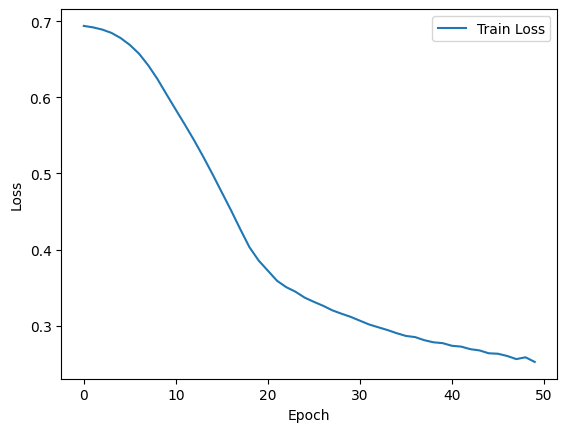

In [27]:
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

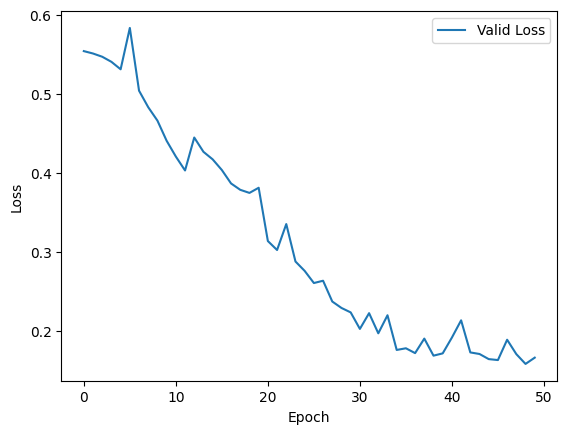

In [28]:
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
y_true = []
y_pred_probs = []
model.eval()
total = 0.0

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(control_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        class_names = ['inactive motion', 'active motion']
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    report = classification_report(y_true, np.argmax(y_pred_probs, axis=1), target_names=class_names)
    print(report)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f' control_accuracy {accuracy}')

                 precision    recall  f1-score   support

inactive motion       0.76      0.99      0.86      1833
  active motion       0.99      0.71      0.83      2007

       accuracy                           0.85      3840
      macro avg       0.88      0.85      0.85      3840
   weighted avg       0.88      0.85      0.84      3840

 control_accuracy 0.8471354166666667


In [41]:
y_true.sum()

2007.0

In [45]:
y_true = []
y_pred_probs = []
model.eval()
total = 0.0

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        class_names = ['inactive motion', 'active motion']
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    report = classification_report(y_true, np.argmax(y_pred_probs, axis=1), target_names=class_names)
    print(report)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'train_accuracy {accuracy}')

                 precision    recall  f1-score   support

inactive motion       0.84      0.99      0.91      7237
  active motion       0.99      0.82      0.90      7611

       accuracy                           0.90     14848
      macro avg       0.91      0.90      0.90     14848
   weighted avg       0.92      0.90      0.90     14848

train_accuracy 0.9019396551724138


In [46]:
y_true = []
y_pred_probs = []
model.eval()
total = 0.0

with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        #optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds, labels.squeeze().long())
        class_names = ['inactive motion', 'active motion']
        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(preds.detach().cpu().numpy())

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    report = classification_report(y_true, np.argmax(y_pred_probs, axis=1), target_names=class_names)
    print(report)
    accuracy = calculate_accuracy(y_true, y_pred_probs)

    print(f'train_accuracy {accuracy}')

                 precision    recall  f1-score   support

inactive motion       0.90      0.97      0.93      1245
  active motion       0.97      0.90      0.93      1315

       accuracy                           0.93      2560
      macro avg       0.94      0.93      0.93      2560
   weighted avg       0.94      0.93      0.93      2560

train_accuracy 0.93359375
